In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict, stack_to_ax

idx = pd.IndexSlice

In [5]:
from data_getter import (
    get_model_balancing_volume
    )

In [6]:
file = Path.cwd().parent / 'summaries' / 'total_summary_flex.csv'
model_balancing_volume = get_model_balancing_volume(file)

c:\Users\lukas\OneDrive\Desktop\projects\nodal\UKLMP\notebooks\data_getter.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bv = pd.read_csv(


In [13]:
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

base_path = Path.cwd().parent / 'data' / 'base'
all_bids = []

# for day in tqdm(sorted(model_balancing_volume.index.get_level_values(0).strftime('%Y-%m-%d').unique())):
for day in tqdm(sorted(os.listdir(base_path))):

    if '2025' in day:
        continue

    try:
        bids = pd.read_csv(base_path / f'{day}' / 'bids.csv', index_col=[0,1], parse_dates=True)
    except FileNotFoundError:
        continue

    all_bids.append(bids)

all_bids = pd.concat(all_bids)

100%|██████████| 1210/1210 [00:08<00:00, 145.44it/s]


In [14]:
bmu_path = Path.cwd().parent / 'data' / 'bmus_prepared.csv'
bmus = pd.read_csv(bmu_path, index_col=0)

In [15]:
idx = pd.IndexSlice

real_bid_vol = all_bids.loc[
    idx[:,'vol'],
    # idx['2022-11','vol'],
    all_bids.columns.intersection(
        bmus
        .index[bmus.carrier.isin(['onwind', 'offwind', 'cascade', 'ror', 'PHS'])]
        )
    # :
].sum(axis=1)

real_bid_vol.index = real_bid_vol.index.droplevel(1)
# real_bid_vol = real_bid_vol.groupby(real_bid_vol.index.strftime('%Y-%m')).sum().mul(1e-3)
real_bid_vol = real_bid_vol.groupby(real_bid_vol.index.strftime('%Y-%m')).sum().mul(1e-3)

In [16]:
mmb = (
    # model_balancing_volume.loc['2022-11', 'national']
    model_balancing_volume.loc[:, 'national']
    .groupby(
        model_balancing_volume# .loc['2022-11']
        .index
        .get_level_values(0)
        .strftime('%Y-%m')
        # .strftime('%Y-%m-%d')
    ).sum()
    .mul(1e3)
)

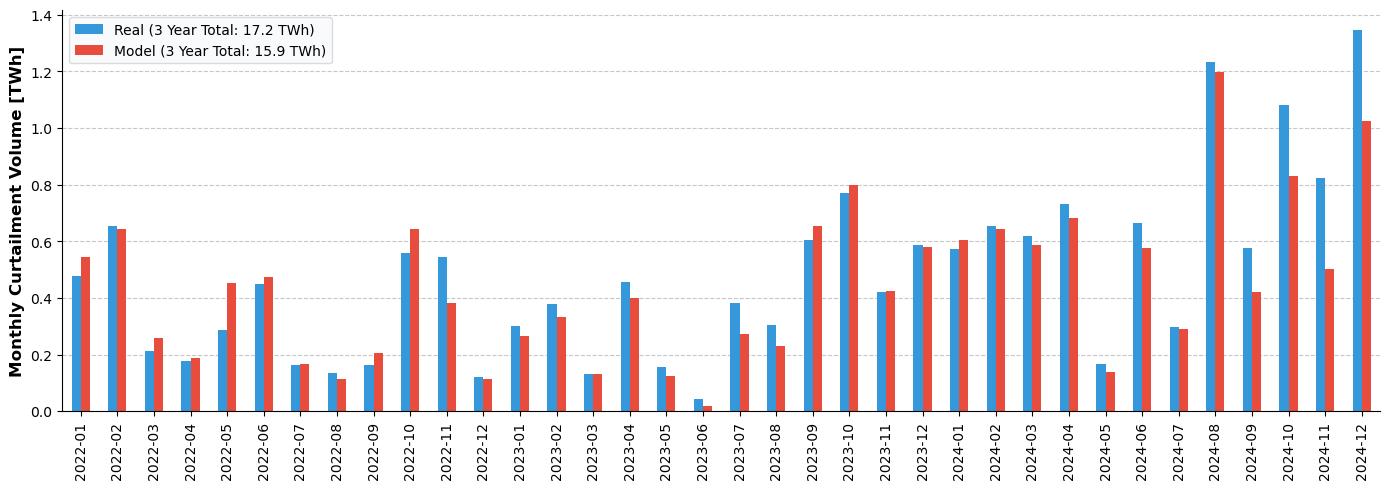

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

plotdata = pd.concat([real_bid_vol, mmb], axis=1).mul(1e-3)
plotdata.columns = ['Real', 'Model']

# Calculate totals for legend
real_total = plotdata['Real'].sum()
model_total = plotdata['Model'].sum()

# Use custom colors
colors = ['#3498db', '#e74c3c']  # Blue for Real, Red for Model

# Plot with custom colors
plotdata.plot.bar(ax=ax, color=colors)

# Add grid below the plot elements
ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
ax.set_axisbelow(True)

# Enhance the y-axis label
ax.set_ylabel('Monthly Curtailment Volume [TWh]', fontsize=12, fontweight='bold')

# Add totals to the legend
handles, labels = ax.get_legend_handles_labels()
labels = [f'Real (3 Year Total: {real_total:.1f} TWh)', f'Model (3 Year Total: {model_total:.1f} TWh)']
ax.legend(handles, labels, frameon=True, facecolor='#f8f9fa', edgecolor='#d3d3d3')

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/balancing_volume_validation.pdf', bbox_inches='tight')
plt.show()

In [18]:
# print('real congestion management bids: ', int(real_bid_vol.drop(index=['2022-11-20', '2022-11-22']).sum().sum()), 'GWh')
# print('model congestion management bids: ', int(mmb.drop(index=['2022-11-20', '2022-11-22']).sum()), 'GWh')
print('real congestion management bids: ', int(real_bid_vol.sum().sum()), 'GWh')
print('model congestion management bids: ', int(mmb.sum()), 'GWh')

real congestion management bids:  17241 GWh
model congestion management bids:  15916 GWh
